# Install Dependencies

In [38]:
!pip install datasets[vision]
!pip install -Uqq fastai
!pip install huggingface_hub
!pip3 install torch torchvision

# Load Dataset

In [157]:
from torch.utils.data import Dataset, DataLoader, random_split

# Load the dataset
dataset = load_dataset("jbarat/plant_species", split="train")

# Define the sizes of the splits
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

Using custom data configuration jbarat--plant_species-efbaed60a3c7fd6e
Reusing dataset parquet (/root/.cache/huggingface/datasets/jbarat___parquet/jbarat--plant_species-efbaed60a3c7fd6e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


# Get Device For Training

In [93]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Define A Custom PyTorch Dataset

In [94]:
from datasets import load_dataset
from PIL import Image as PILImage
from io import BytesIO
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

# Define a function to convert bytes to PILImage
def bytes_to_pil(bytes):
    pil_image = PILImage.open(BytesIO(bytes))
    return pil_image

class PlantSpeciesDataset(Dataset):
    def __init__(self, train_dataset):
        self.train_dataset = train_dataset
        self.transform = transforms.Compose([transforms.Resize((224,224)),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def __getitem__(self, index):
        example = self.train_dataset[index]
        image_bytes = example['image']['bytes']
        label = example['label']
        pil_image = bytes_to_pil(image_bytes)
        image = self.transform(pil_image)
        return image, label

    def __len__(self):
        return len(self.train_dataset)

# Create an instance of the custom dataset
custom_dataset = PlantSpeciesDataset(train_dataset)

# Create a PyTorch DataLoader
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Iterate over the DataLoader
for i, batch in enumerate(dataloader):
    images, labels = batch
    # Do something with the batch of images and labels
    print(f"Batch {i}: Images shape - {images.shape}, Labels shape - {labels.shape}")


Batch 0: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 1: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 2: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 3: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 4: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 5: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 6: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 7: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 8: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 9: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 10: Images shape - torch.Size([32, 3, 224, 224]), Labels shape - torch.Size([32])
Batch 11: Images shape - torch.Size([32, 3

# Define Model

In [97]:
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 56 * 56, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
).to(device)

# Define Loss Function And Optimizer

In [98]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [99]:
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

Epoch [1/5], Step [10/20], Loss: 2.2123
Epoch [1/5], Step [20/20], Loss: 1.9676
Epoch [2/5], Step [10/20], Loss: 1.7819
Epoch [2/5], Step [20/20], Loss: 1.9717
Epoch [3/5], Step [10/20], Loss: 1.8733
Epoch [3/5], Step [20/20], Loss: 1.3735
Epoch [4/5], Step [10/20], Loss: 1.0228
Epoch [4/5], Step [20/20], Loss: 1.0117
Epoch [5/5], Step [10/20], Loss: 0.6905
Epoch [5/5], Step [20/20], Loss: 0.3486


# Evaluate Model

In [100]:
model.eval()
test_custom_dataset = PlantSpeciesDataset(test_dataset)
test_dataloader = DataLoader(test_custom_dataset, batch_size=32, shuffle=False)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

Accuracy on the test set: 35.62%


# Visualize Results

In [103]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['aechmea_fasciata', 'agave_americana', 'agave_attenuata', 'agave_tequilana', 'aglaonema_commutatum',
               'albuca_spiralis', 'allium_cepa', 'allium_sativum']

# get a batch of images and their corresponding labels from the dataloader
images, labels = next(iter(test_dataloader))

# move the batch of images and labels to the device
images = images.to(device)
labels = labels.to(device)

# make predictions on the batch of images
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

# convert the tensor to numpy array
images = images.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

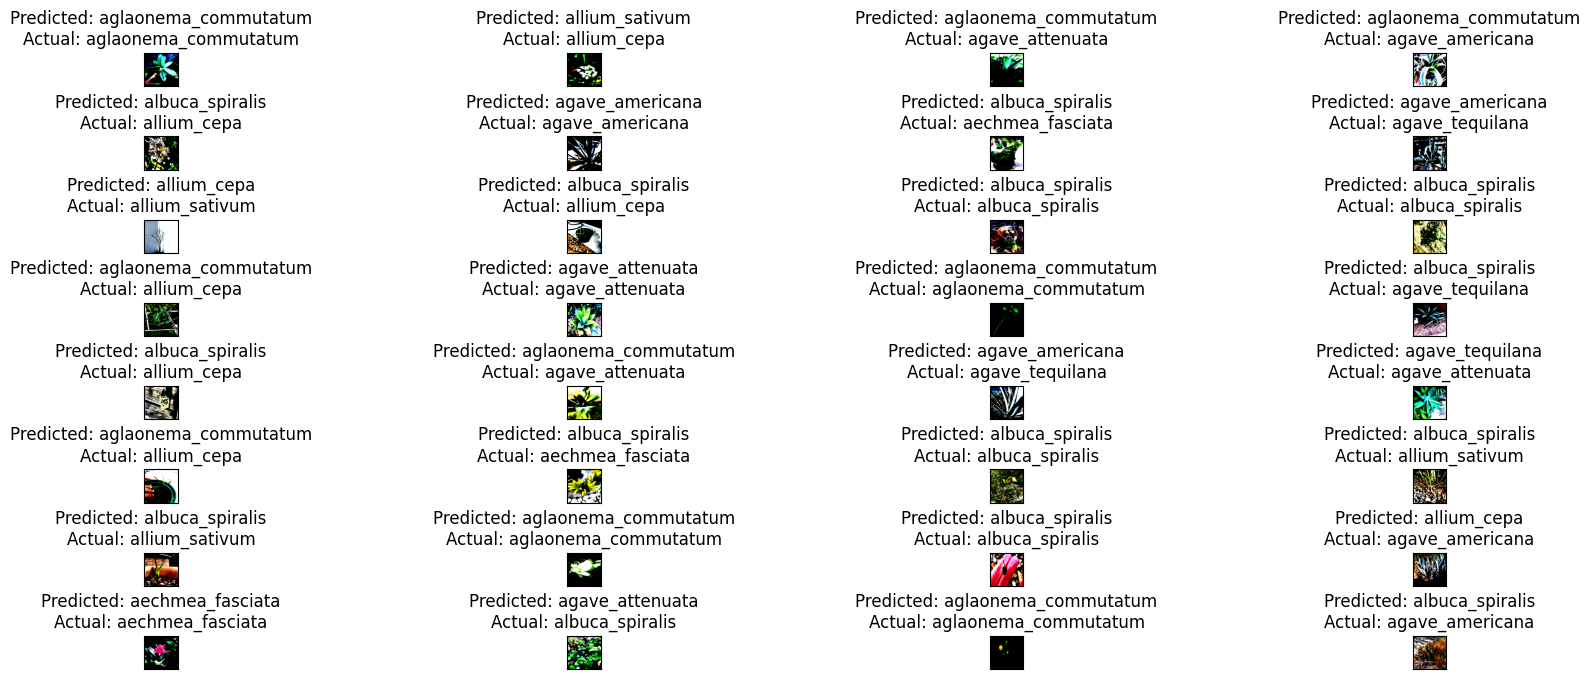

In [109]:
# plot the images with their predicted and actual labels
fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(hspace=1.5, wspace=0.5)
for i in range(32):
    ax = fig.add_subplot(8, 4, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(f"Predicted: {class_names[predicted[i]]}\nActual: {class_names[labels[i]]}")

# Using FastAI

In [156]:
from fastai.vision.all import *

# Define the transforms
transforms = [Resize((224, 224)), Normalize.from_stats(*imagenet_stats)]

# Define the data block
blocks = (ImageBlock, CategoryBlock)
plant_species = DataBlock(blocks=blocks,  
                          get_x = lambda x: PILImage.create(BytesIO(x['image']['bytes'])),
                          get_y=lambda x: x['label'],
                          item_tfms=RandomResizedCrop(224, min_scale=0.5),
                          batch_tfms=transforms)

# Create the dataloader
dataloader = plant_species.dataloaders(dataset, bs=4)

# Define the learner
learn = cnn_learner(dataloader, resnet50, metrics=accuracy)

# Train the model
learn.fine_tune(10)

Using custom data configuration jbarat--plant_species-efbaed60a3c7fd6e
Reusing dataset parquet (/root/.cache/huggingface/datasets/jbarat___parquet/jbarat--plant_species-efbaed60a3c7fd6e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


epoch,train_loss,valid_loss,accuracy,time
0,2.247181,1.685500,0.550000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,1.355158,1.204969,0.656250,00:15
1,1.511131,1.109877,0.693750,00:15
2,1.650321,1.224565,0.618750,00:15
3,1.333148,0.959663,0.737500,00:14
4,1.207920,1.081603,0.706250,00:14
5,0.992921,0.853467,0.750000,00:15
6,0.914620,0.714264,0.787500,00:15
7,0.704918,0.779608,0.775000,00:13
8,0.655743,0.597717,0.831250,00:14
9,0.556382,0.628709,0.831250,00:14


# Evaluate The Model

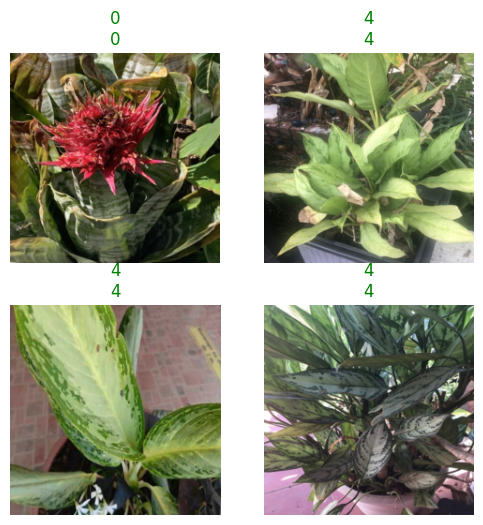

In [158]:
learn.show_results()

In [169]:
learn.predict(plant_species.get_x(test_dataset[120]))

('2',
 tensor(2),
 tensor([3.5382e-07, 4.4966e-08, 1.0000e+00, 2.0749e-08, 5.9947e-08, 4.9629e-08,
         5.9000e-07, 1.8787e-07]))

In [170]:
plant_species.get_y(test_dataset[120])

2